In [35]:
## Importing the packages we'll use
import numpy as np              # numerical python
import matplotlib.pyplot as plt # plotting
import batman                   # homogeneous limb transit modeling
import catwoman                 # asymmetric limb transit modeling
import emcee                    # MCMC sampling package
from multiprocessing import Pool # easy multiprocessing with emcee

In [106]:
## Functions that will be used ...
def calc_scale_height(T, M, R, mm=2):
    """ Calculates the approximate scale height of a planet's atmosphere, using the equation
     scale height = kT / mg
    
    Inputs: T = the atmospheric temperature in [K]; M = the planet's mass in [Mjupiter]; 
            R = the planet's radius in [Rjupiter]; mm = mean mass of a molecule in the atmosphere [amu], this is
                   default set to 1 amu = 1 proton mass (for now)
    Outputs: H = the scale height in [km]
    """
    # constants:
    amu = 1.67e-27 # [kg]; atomic mass unit in [kg]
    k = 1.38e-23 # [Joule/K]; Boltzmann constant
    G = 6.674e-11 # [m^3/kg/s^2]; Gravitational constant
    Mjupiter = 1.9e27 # [kg]; mass of Jupiter
    Rjupiter = 69911000.0 # [m]; approx. radius of Jupiter
    
    # computing the numerator for the scale height equation:
    E_thermal = k*T # [Joule]
    
    # computing the denominator:
    M_kg, R_m = M*Mjupiter, R*Rjupiter # convert planet quantities into SI units
    g = G*M_kg/(R_m**2) # gravitational acceleration in [m/s^2]
    meanmass = mm*amu
    denominator = meanmass*g # [kg*m/s^2]
    
    # compute the scale height:
    H = E_thermal / denominator # [meters]
    H /= 1000. # convert to [km] from [m]
    
    return H

def convert_rprs_to_rpJ(rprs, rs):
    """ Converts the planet-star radius ratio into the planet's radius in Jupiter radii
    Inputs: rprs = planet-star radius ratio; rs = stellar radius in [Rsun]
    Outputs: rp = planet radius in [RJupiter]
    """
    # compute planet radius in [solar radii]
    rp_s = rprs*rs # [Rsol]
    # convert [solar radii] to [jupiter radii]
    rp_J = rp_s * 9.73116
    
    return rp_J

def convert_rpJ_to_rprs(rpJ, rs):
    """ Converts a planet radius to the planet-star radius ratio
    Inputs: rpJ = planet radius in [Rjupiter], rs = stellar radius in [Rsun]
    Outputs: rprs = planet-star radius ratio
    """
    # convert planet radius to [Rsol]
    rp_s = rpJ / 9.73116
    # divide by stellar radius (in [Rsol])
    rprs = rp_s / rs
    
    return rprs

def convert_km_to_rpJ(km):
    """ Converts a quantity in [km] to [Jupiter radii]"""
    d = km / 71492.
    return d

def logLikelihood(ydata, yerr, modely):
    """ Computes the Bayesian likelihood of a model, given the data (or is it the other way around?)
    Inputs: ydata = your data, yerr= uncertainties on your data, modely = same size array of the model's values
    outputs: ln( the likelihood )
    """
    lnL = 0.
    chi_array = ((ydata - modely) ** 2. / yerr ** 2.) + np.log(2. * np.pi * yerr ** 2.)
    lnL += -0.5 * np.sum(chi_array)
    
    return lnL

def logPriors(theta, info_dict):
    """ Computes the Bayesian prior value, given the current set of parameter values
    Inputs: theta = array of parameter values, info_dict = a dictionary that defines which parameters are having
        priors enforced, which type, and of what bounds/values
    Output: ln(the prior value)
    """
    lnP_runsum = 0.
    for i, key in enumerate(info_dict['Prior'].keys()):
        if info_dict['Prior'][key][2] == 'U':
            l1, l2 = info_dict['Prior'][key][0][0], info_dict['Prior'][key][0][1]
            if not (l1 <= theta[i] <= l2):
                return -np.inf
        elif info_dict['Prior'][key][2] == 'N':
            pval, perr = info_dict['Prior'][key][0], info_dict['Prior'][key][1]
            lnP_runsum += -(theta[i] - pval) ** 2. / (2. * perr ** 2.) - np.log(np.sqrt(2. *perr **2. * np.pi))
    
    return lnP_runsum

def homog_transit_model(theta, InitModel):
    """
    Input to the MCMC. Given a set of parameters (theta) and an initialized BATMAN environment (InitModel),
        outputs the model lightcurve array\
    Note: Will need to adjust this function when changing what parameters are free in the MCMC
    """
    Params = batman.TransitParams()
    Params.t0 = theta[0]
    Params.per = 10.**(theta[1])
    Params.rp = np.mean((rprs1, rprs2))
    Params.a = lit_params['a'][0]
    Params.inc = lit_params['inc'][0]
    Params.ecc = 0.
    Params.w = 90.
    Params.u = [lit_params['u1'][0], lit_params['u2'][0]]  # these are set arbitrarily
    Params.limb_dark = 'quadratic'
    step_lc = InitModel.light_curve(Params)
    return step_lc

def lnPosterior(theta, flux, flux_errors, info_dict, init_transitmodel):
    """
    Input to the MCMC. Computes the Bayesian posterior
    """
    # compute and check priors
    lnPrior = logPriors(theta, info_dict)
    if not np.isfinite(lnPrior):
        return -np.inf
    
    # compute transit model and resulting likelihood
    transit_model_lc = homog_transit_model(theta, init_transitmodel)
    lnLikelihood = logLikelihood(flux, flux_errors, transit_model_lc)
    
    # compute posterior
    lnPost = lnPrior + lnLikelihood
    
    return lnPost

def compute_bic(Nparams, Ndata, max_lnL):
    """computes the bayesian information criterion"""
    bic = Nparams*np.log(Ndata) - 2.*max_lnL
    return bic

def compute_chi2(ydata, yerr, modely, reduced=True, Ndof=1):
    chi2vals = (ydata - modely)**2 / yerr**2
    chi2 = np.sum(chi2vals)
    
#     runningSum = 0.
#     for i, y in enumerate(ydata):
#         runningSum += ((ydata[i] - modely[i])**2 / (yerr[i]**2))
#     chi2 = runningSum
    if reduced:
        chi2red = chi2 / Ndof
        return chi2red
    else:
        return chi2


#### Generating the Model

In [127]:
## First, let's generate an intrinsically asymmetric lightcurve
# I'll use parameters for WASP-96 b
c = 1. / np.log(10.)  # useful constant for computing uncertainties of logarithmic quantities
lit_params = {
    # array order: 0 = value, 1 = uncertainty, 2 = unit, 3 = source
    't0':np.array([2459111.30170, 0.00031, 'days', 'Hellier+ 2014'],dtype=object),
    'P':np.array([3.4252565, 0.0000008, 'days', 'Kokori+ 2022'], dtype=object),
    'log10P':np.array([np.log10(3.4252565), ((c*0.0000008)/3.4252565), 'unitless', 'calculated'], dtype=object),
    'a':np.array([9.03, 0.3, 'Rs', 'Patel & Espinoza 2022'], dtype=object),
    'log10a':np.array([np.log10(9.03), ((c*0.3)/ 9.03), 'unitless', 'calculated'], dtype=object),
    'RpRs':np.array([0.1186, 0.0017, 'unitless', 'Patel & Espinoza 2022'], dtype=object),
    #'RpRs':np.array([0.1158, 0.0017, 'unitless', 'pre determined for this band'], dtype=object),
    'Rs':np.array([1.15, 0.03, 'Rsun', 'Gaia DR2'], dtype='object'),
    'Mp':np.array([0.49, 0.04, 'Mjupiter', 'Bonomo+ 2017'], dtype='object'),
    'Teq':np.array([1285., 40., 'K', 'Hellier+ 2014'], dtype='object'),
    'inc':np.array([85.6, 0.2, 'degrees', 'Hellier+ 2014'], dtype=object),
    'cosi':np.array([np.cos(85.6*(np.pi/180.)), np.sin(85.6*(np.pi/180.))*(0.2*(np.pi/180.)), 'unitless', 'calculated'], dtype=object),
    'u1':np.array([0.1777, 0.5, 'unitless', 'Claret+ 2011 tabulation'], dtype=object), # note: this uncertainty set arbitrarily
    'u2':np.array([0.2952, 0.5, 'unitless', 'Claret+ 2011 tabulation'], dtype=object) # note: this uncertainty set arbitrarily
}

## Setting an initial degree of asymmetry
# Note: in catwoman, when phi = 90 (as I'll assume), rp = the trailing limb Rp/Rs, 
#          and rp2 = the leading limb Rp/Rs
# I'll first try quantifying the difference between the limb sizes in units of the planet's scale height

asymmetry_factor1 = 10. # number of scale heights by which the limbs differ in radius

# set trailing limb Rp/Rs to literature homogeneous Rp/Rs
rprs1 = lit_params['RpRs'][0]  
# compute trailing limb radius in [Rjupiter]
rp1 = convert_rprs_to_rpJ(rprs1, lit_params['Rs'][0]) 
# compute corresponding scale height in [km]
H1 = calc_scale_height(lit_params['Teq'][0], lit_params['Mp'][0], rp1, mm=2)
# convert this scale height into [Rjupiter]
H1_rJ = convert_km_to_rpJ(H1)
# using the pre-defined asymmetry factor, compute the leading limb's radius in [Rjupiter]
rp2 = rp1 + (asymmetry_factor1 * H1_rJ)
# convert this to an Rp/Rs ratio
rprs2 = convert_rpJ_to_rprs(rp2, lit_params['Rs'][0])

print('Trailing Limb:')
print('Rp/Rs = %.4f'%(rprs1))
print('Rp = %.2f RJupiter'%(rp1))
print('Leading Limb:')
print('Rp/Rs = %.4f'%(rprs2))
print('Rp = %.2f RJupiter'%(rp2))

Trailing Limb:
Rp/Rs = 0.1186
Rp = 1.33 RJupiter
Leading Limb:
Rp/Rs = 0.1278
Rp = 1.43 RJupiter


In [128]:
## using an arbitrary time axis for now
## note - replace this later with true time array from the observed data or something general
time = np.linspace(lit_params['t0'][0]-3./24., lit_params['t0'][0]+3./24., 350)

In [129]:
## Creating an initialized CATWOMAN model for the asymmetric limb transit
InitAsymParams = catwoman.TransitParams()
InitAsymParams.t0 = lit_params['t0'][0] # transit midpoint in [day]
InitAsymParams.per = lit_params['P'][0] # orbital period in [day]
InitAsymParams.rp = rprs1 # trailing limb RpRs
InitAsymParams.rp2 = rprs2 # leading limb RpRs
InitAsymParams.a = lit_params['a'][0] # semi-major axis in [Rsol]
InitAsymParams.inc = lit_params['inc'][0] # inclination in [deg]
InitAsymParams.ecc = 0. # eccentricity
InitAsymParams.w = 90. # argument of periastron?
InitAsymParams.u = [lit_params['u1'][0], lit_params['u2'][0]]  # limb darkening coefficients
InitAsymParams.phi = 90. # 90 - obliquity [deg]
InitAsymParams.limb_dark = 'quadratic' # type of limb darkening law to use
InitAsymModel = catwoman.TransitModel(InitAsymParams, time)
init_asym_lc = InitAsymModel.light_curve(InitAsymParams)

#### Generating the Synthetic Observation (optional)

In [130]:
## Generating synthetic observed data around the asymmetric model
##   Use this synthetic data so that you can adjust the scatter and uncertainty
scatter = 200. # [ppm], standard deviation of flux values about the model
flux_uncertainty = scatter # [ppm], uncertainty on each flux point

syn_fluxes, syn_errs = np.zeros(time.shape), np.zeros(time.shape)
for i_point, time_value in enumerate(time):
    # get the model value at this point
    model_val = init_asym_lc[i_point]
    # set the data point somewhere in a normal distribution about the model value
    flux_val = model_val + np.random.normal(loc=0, scale=(scatter/1.e6))
    
    syn_fluxes[i_point] = flux_val
    syn_errs[i_point] = (flux_uncertainty / 1.e6)

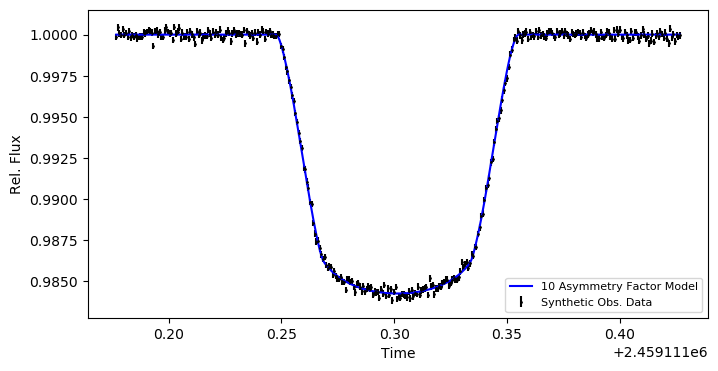

In [131]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(time, init_asym_lc, c='blue', label='%d Asymmetry Factor Model'%(asymmetry_factor1))
#ax.scatter(time, syn_fluxes, c='black', s=1, label='Synthetic Obs. Data')
ax.errorbar(time, syn_fluxes, syn_errs, ls='None', marker='o', c='black', ms=1, label='Synthetic Obs. Data')
ax.set(xlabel='Time', ylabel='Rel. Flux')
ax.legend(loc='lower right', fontsize=8)
plt.show()

To do:
- set up an MCMC for a batman model with only ephemerides as free parameters (maybe start with just the transit time being free)
- give it a uniform prior bounding, e.g. can only shift +/- 20 minutes, and this limit will be the output requisite precision needed.
- maybe test cases where RpRs = literature value, and where RpRs = average of the two asym model radii

In [132]:
## Defining the info dict
fit_pars = {
    'Init':{
        # Initialization values
        't0':lit_params['t0'][0],
        'log10P':lit_params['log10P'][0]
    },
    'Prior':{
        # Bayesian priors
        # 0 = prior value or prior bounds if type = uniform, 1 = prior error (also initialization ball size), 2 = prior type
        't0':np.array([(lit_params['t0'][0]-3.*lit_params['t0'][1], lit_params['t0'][0]+3.*lit_params['t0'][1]), lit_params['t0'][1], 'U'], dtype=object),
        'log10P':np.array([(lit_params['log10P'][0]-3.*lit_params['log10P'][1], lit_params['log10P'][0]+3.*lit_params['log10P'][1]), lit_params['log10P'][1], 'U'], dtype=object),
    }
}
print('Parameters being fit for:')
print((fit_pars['Init'].keys()))

## Creating an initialized BATMAN model for the homogeneous limb transit
InitHomogParams = batman.TransitParams()
InitHomogParams.t0 = lit_params['t0'][0] # transit midpoint in [day]
InitHomogParams.per = lit_params['P'][0] # orbital period in [day]
InitHomogParams.rp = np.mean((rprs1, rprs2))
InitHomogParams.a = lit_params['a'][0] # semi-major axis in [Rsol]
InitHomogParams.inc = lit_params['inc'][0] # inclination in [deg]
InitHomogParams.ecc = 0. # eccentricity
InitHomogParams.w = 90. # argument of periastron?
InitHomogParams.u = [lit_params['u1'][0], lit_params['u2'][0]]  # limb darkening coefficients
InitHomogParams.phi = 90. # 90 - obliquity [deg]
InitHomogParams.limb_dark = 'quadratic' # type of limb darkening law to use
InitHomogModel = batman.TransitModel(InitHomogParams, time)
init_homog_lc = InitHomogModel.light_curve(InitHomogParams)

Parameters being fit for:
dict_keys(['t0', 'log10P'])


In [133]:
Nparams = len(fit_pars['Init'].keys())
theta_init = np.zeros(Nparams)
theta_init_errs = np.zeros(Nparams)
for i, key in enumerate(fit_pars['Init'].keys()):
    theta_init[i] = fit_pars['Init'][key]
    theta_init_errs[i] = fit_pars['Prior'][key][1]
print('\n')
print('Initial parameter array = ', theta_init)
initial_lnPrior = logPriors(theta_init, fit_pars)
initial_lnPost = lnPosterior(theta_init, syn_fluxes, syn_errs, fit_pars, InitHomogModel)
initial_lnLikelihood = initial_lnPost - initial_lnPrior
print('N parameters = ', Nparams)
print('Initial ln Prior = ', initial_lnPrior)
print('Initial ln Likelihood = ', initial_lnLikelihood)
print('Initial ln Posterior = ', initial_lnPost)
print('\n')

Nwalkers = 3*Nparams
Nsteps = 50000
Nburn = 1000

# initializing the MCMC walkers
pos = np.zeros((Nwalkers, Nparams))
for j in range(Nparams):
    pos[:,j] = theta_init[j] + 0.5*np.random.normal(0., theta_init_errs[j], Nwalkers)
print('%d walkers initialized'%(Nwalkers))
print('Running for %d steps, including %d step burn-in'%(Nsteps, Nburn))
with Pool() as pool:
    sampler = emcee.EnsembleSampler(Nwalkers, Nparams, lnPosterior, pool=pool, 
                                 args=(syn_fluxes, syn_errs, fit_pars, InitHomogModel))
    state = sampler.run_mcmc(pos, Nsteps, progress=True)

samples = sampler.get_chain(discard=Nburn)
flatsamples = sampler.get_chain(discard=Nburn, flat=True)
loglikelihoods = sampler.get_log_prob(discard=Nburn, flat=True)
autocorrtimes = sampler.get_autocorr_time()



Initial parameter array =  [2.45911130e+06 5.34693099e-01]
N parameters =  2
Initial ln Prior =  0.0
Initial ln Likelihood =  2430.121053983383
Initial ln Posterior =  2430.121053983383


6 walkers initialized
Running for 50000 steps, including 1000 step burn-in


100%|██████████| 50000/50000 [01:05<00:00, 757.83it/s]


In [134]:
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
param_errs = np.mean((param_uperrs, param_loerrs), axis=0)

print('For the best fit Homogeneous model:')
print('Best fit parameters = ', param_fits)
print('errors = ', param_errs)
print('auto correlation times = ', autocorrtimes)
bf_lnPrior = logPriors(param_fits, fit_pars)
bf_lnPost = lnPosterior(param_fits, syn_fluxes, syn_errs, fit_pars, InitHomogModel)
bf_model = homog_transit_model(param_fits, InitHomogModel)
bf_lnLikelihood = logLikelihood(syn_fluxes, syn_errs, bf_model)
bf_bic = compute_bic(len(param_fits), len(syn_fluxes), bf_lnLikelihood)
bf_chi2red = compute_chi2(syn_fluxes, syn_errs, bf_model, reduced=True, Ndof=(len(time) - Nparams))


data_asym_residuals = syn_fluxes - init_asym_lc
mean_daresidual = np.mean(data_asym_residuals) # should these be absolute valued?
data_homog_residuals = syn_fluxes - bf_model
mean_dhresidual = np.mean(data_homog_residuals)
asym_homog_residuals = init_asym_lc - bf_model
mean_ahresidual = np.mean(asym_homog_residuals)

print('Final ln Prior = ', bf_lnPrior)
print('Final ln Likelihood = ', bf_lnLikelihood)
print('Final ln Posterior = ', bf_lnPost)
print('Final BIC = ', bf_bic)
print('Final reduced chi2 = ', bf_chi2red)
print('\n')

print('For the true asymmetric model:')
true_lnLikelihood = logLikelihood(syn_fluxes, syn_errs, init_asym_lc)
true_bic = compute_bic(len(param_fits), len(syn_fluxes), true_lnLikelihood)
true_chi2red = compute_chi2(syn_fluxes, syn_errs, init_asym_lc, reduced=True, Ndof=len(time))
print('True ln Likelihood = ', true_lnLikelihood)
print('True BIC = ', true_bic)
print('True reduced chi2 = ', true_chi2red)
print('\n')

print('Mean Asym. Model - Homog. Model residual = %.0f ppm'%(1.e6*mean_ahresidual))
print('Mean Syn. Data - Homog. Model residual = %.0f ppm'%(1.e6*mean_dhresidual))
print('Mean Syn. Data - Asym. Model residual = %.0f ppm'%(1.e6*mean_daresidual))
print('Mean Syn. Data Uncertainty = %.0f ppm'%(1.e6*np.mean(syn_errs)))
print('Flux Scatter = %.0f ppm'%(scatter))





For the best fit Homogeneous model:
Best fit parameters =  [2.45911130e+06 5.34693106e-01]
errors =  [3.76065727e-05 2.07275867e-07]
auto correlation times =  [42.80264915 48.21668947]
Final ln Prior =  0.0
Final ln Likelihood =  2460.8918307181493
Final ln Posterior =  2460.8918307181493
Final BIC =  -4910.067795127332
Final reduced chi2 =  1.1407890784821746


For the true asymmetric model:
True ln Likelihood =  2460.9884344053203
True BIC =  -4910.261002501674
True reduced chi2 =  1.1337182626784426


Mean Asym. Model - Homog. Model residual = -7 ppm
Mean Syn. Data - Homog. Model residual = -8 ppm
Mean Syn. Data - Asym. Model residual = -1 ppm
Mean Syn. Data Uncertainty = 200 ppm
Flux Scatter = 200 ppm


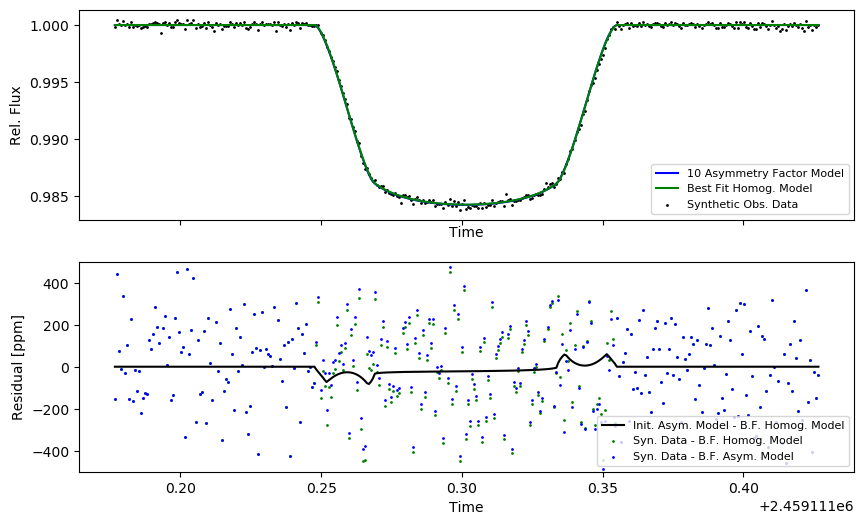

In [135]:
fig, ax = plt.subplots(figsize=(10,6), nrows=2, sharex=True)
ax0, ax1 = ax[0], ax[1]
ax0.plot(time, init_asym_lc, c='blue', label='%d Asymmetry Factor Model'%(asymmetry_factor1))
ax0.scatter(time, syn_fluxes, c='black', s=1, label='Synthetic Obs. Data')
ax0.plot(time, bf_model, c='green', label='Best Fit Homog. Model')
ax0.set(xlabel='Time', ylabel='Rel. Flux')
ax0.legend(loc='lower right', fontsize=8)

ax1.plot(time, 1.e6*asym_homog_residuals, c='black', label='Init. Asym. Model - B.F. Homog. Model')
ax1.scatter(time, 1.e6*data_homog_residuals, c='green', s=1, label='Syn. Data - B.F. Homog. Model')
ax1.scatter(time, 1.e6*data_asym_residuals, c='blue', s=1, label='Syn. Data - B.F. Asym. Model')
ax1.set(xlabel='Time', ylabel='Residual [ppm]', ylim=(-500, 500))
ax1.legend(loc='lower right', fontsize=8)
plt.show()